# 1. READ EEG

In [6]:
import mne
import pandas as pd

# define function
def read_eeg(vhdr_fname):
    # define list of indicies for non-eeg channels
    misc_list = []
    for i in range(18):
        misc_list.append(i+64)

    # read raw data
    raw = mne.io.read_raw_brainvision(vhdr_fname, misc=misc_list, preload=True,
        verbose=False)
    raw.info['line_freq'] = 500.

    # Set montage
    montage = mne.channels.make_standard_montage('easycap-M1')
    raw.set_montage(montage, verbose=False)

    # Set common average reference
    raw.set_eeg_reference('average', projection=False, verbose=False)

    # create pandas dataframe with eeg data
    eeg_data = pd.DataFrame(raw.get_data().transpose(), columns=raw.ch_names)

    # Temporarily drop T7 while it's broken
    eeg_data = eeg_data.drop(columns=["T7"])

    # hardcoding the start time to align with tobii pro recording
    eeg_data = eeg_data.iloc[15060:,:].reset_index().drop('index', axis=1)

    return eeg_data

# 2. DECISION TREE EPOCH DETECTION

In [7]:
# import libraries
import pandas as pd
import math
# import class
from sklearn.tree import DecisionTreeRegressor

def decisionTree_epochDetection(num_bins,Xy_array):
    # exception handling
    # max_leaf_nodes must either be None or larger than 1
    # therefore num_bins must be at least 2
    if(num_bins < 2):
        print("num_bins must be greater than one")
        print("Changing value of num_bins to minimum possible value")
        num_bins = 2
    # fitting the regression tree X as features/predictor and y as label/target
    clf = DecisionTreeRegressor(max_leaf_nodes = num_bins).fit(Xy_array[:,0].reshape(-1, 1), Xy_array[:,1])

    # variables creation
    num_nodes = clf.tree_.node_count
    left_child = clf.tree_.children_left
    right_child = clf.tree_.children_right
    threshold = clf.tree_.threshold
    # list to store the bin edges
    bin_edges = [0,len(Xy_array)-1]

    # loop through all the nodes
    for i in range(num_nodes):
        # If the left and right child of a node is not the same(-1) we have an internal node
        # which we will append to bin_node list
        if left_child[i]!=right_child[i]:
            bin_edges.append(math.ceil(threshold[i]))
    # sort the nodes in increasing order
    bin_edges.sort()
    # create dictionary to store epoch bin edges
    epoch_dict = {}
    # put in each dictionary index 2 consecutive bin edges
    for i in range(num_bins):
        epoch_dict[str(i+1)] = [bin_edges[i], bin_edges[i+1]]
    return epoch_dict

# 3.1 EPOCH BM DICTIONARY

In [8]:
# import modules
import mne
import numpy as np
import pandas as pd

# import functions
from scipy import signal
# from biometricVar_per_epoch import *

# define function
def getEpochbm_dict(eeg_data, epoch_dict):

    df = eeg_data.iloc[:, 0:64]     # create dataframe for 64 signals
    fs = 500                        # Sampling rate of 500 Hz
    epochbm_dict = dict()           # final dictionary
    
    # Read dictionary with non-eeg data
    non_eeg_dict = biometricVar_per_epoch(epoch_dict, eeg_data)
    
    # Define EEG frequency bands
    bands = {'Delta': (1, 3),
             'Theta': (4, 7),
             'Alpha': (8, 12),
             'Beta': (13, 25),
             'Gamma': (26, 45)}

    # Outer loop iterates through epoch dictionary and creates a dataframe for
    # each epoch based on its time index range and stores it along with the index
    # ranges in the final dictionary
    for e in epoch_dict:
        start_idx = epoch_dict[e][0]    # beginning time index range
        end_idx = epoch_dict[e][1]      # ending time index range

        eeg_list = []                   # list of band dictionaries
        idx_name = []                   # name of electrodes

        # slice dataframe according to epoch edges
        epoch_df = df[start_idx:end_idx]

        # inner loop goes through each column of the sliced dataframe applies the
        # welch function and stores the dictionaries in a list
        for i in epoch_df:
            idx_name.append(i)          # store name of electrode
            eeg_bands = dict()          # dictionary holding EEG bands as keys and freq as value

            # Take one electrode at a time from dataframe
            data_col = epoch_df.loc[:, i]
            eeg_signal = data_col.values

            # welch function applied to each electrode using sampling rate
            freq_arr, psd_arr = signal.welch(eeg_signal, fs)

            # find freq bands of all electrodes for given epoch and store in dictionary
            for b in bands:
                # Find frequency match with EEG bands
                freq_ix = np.where((freq_arr >= bands[b][0]) & (freq_arr <= bands[b][1]))

                # Calculate the mean of power spectrum value
                eeg_bands[b] = np.mean(psd_arr[freq_ix])

            # add band dictionary to list of dictionaries
            eeg_list.append(eeg_bands)

        # create new dataframe for freq bands of each electrode for given epoch
        bands_df = pd.DataFrame(eeg_list, columns=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'], index=idx_name)

        # add time index ranges and both EEG and non-EEG biometric dataframes to final dictionary in each epoch
        epochbm_dict[e] = [[start_idx, end_idx], bands_df, non_eeg_dict[e][1]]

    # print(epochbm_dict)
    return epochbm_dict

# 3.2 BIOMETRIC VAR PER EPOCH

In [67]:
def biometricVar_per_epoch(epoch_dict, eeg_data):
    #import library
    import pandas as pd
    from sklearn_som.som import SOM
    from sklearn.preprocessing import MinMaxScaler
    
    # define output dictionary
    epochbm_dict={}
    # SpO2 vals
    eeg_data.SpO2 = eeg_data.SpO2*pow(10,6)
    # list to store column names we want to access from the dataframe
    df_cols = ['ECG.', 'Resp.', 'PPG', 'SpO2', 'HR', 'GSR', 'Temp.']
    # apply rolling average to dataframe comprising of df_cols 
    rolled_df = eeg_data.loc[:,df_cols].rolling(window=5000).mean()
    roll_np = eeg_data.loc[:,df_cols].rolling(window=5000).mean().dropna().to_numpy()

    # Apply MinMaxScaling and do SOM
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(roll_np)

    bio_som = SOM(m=3, n=1, dim=7)
    bio_som.fit(roll_np)
    predictions = bio_som.predict(roll_np)
    rolled_df.loc[5000:,'SOM Class'] = pd.Series(predictions)
    # print(rolled_df['SOM Class'].describe())

    # populate the output dictionary
    for key, value in epoch_dict.items():
        epochbm_dict[key]=[epoch_dict[key],rolled_df.loc[range(value[0], value[1])]]
    
    # print(epochbm_dict)
        
    return epochbm_dict

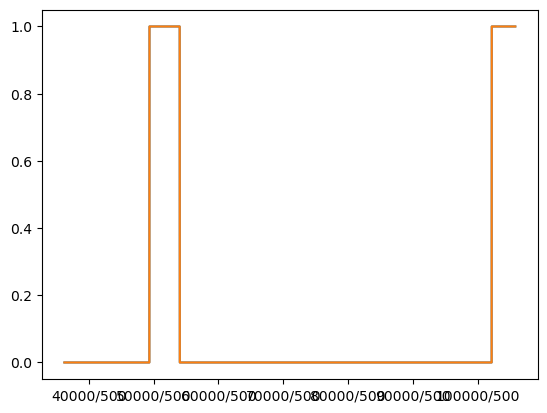

In [86]:
SOM_dicts['2'][1]['SOM Class'].plot()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%d/500"))
plt.show()

In [68]:
SOM_dicts = biometricVar_per_epoch(epochs, full_df)

In [42]:
som_df = full_df.loc[:,['ECG.', 'Resp.', 'PPG', 'SpO2', 'HR', 'GSR', 'Temp.']].rolling(window=5000).mean()

In [47]:
som_np = full_df.loc[:,['ECG.', 'Resp.', 'PPG', 'SpO2', 'HR', 'GSR', 'Temp.']].rolling(window=5000).mean().dropna().to_numpy()
som_np

array([[-1.20053426e-03,  3.94813007e+01,  1.63867492e+04, ...,
         8.14616000e+01,  1.15737206e+05,  3.02882125e+01],
       [-1.20051487e-03,  3.94815025e+01,  1.63867556e+04, ...,
         8.14624000e+01,  1.15737206e+05,  3.02881875e+01],
       [-1.20049278e-03,  3.94817042e+01,  1.63867620e+04, ...,
         8.14632000e+01,  1.15737206e+05,  3.02881625e+01],
       ...,
       [-2.46576841e-03,  4.14658785e+01,  1.63843686e+04, ...,
         9.22588000e+01,  1.15737206e+05,  3.01374500e+01],
       [-2.46573949e-03,  4.14658785e+01,  1.63843948e+04, ...,
         9.22586000e+01,  1.15737206e+05,  3.01374500e+01],
       [-2.46571088e-03,  4.14658785e+01,  1.63844224e+04, ...,
         9.22584000e+01,  1.15737206e+05,  3.01374500e+01]])

In [54]:
som_df = som_df.drop("SOM Class", axis=1)

In [59]:
np.insert(predictions, (0,5000) , 0)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [60]:
len(predictions)

262619

In [64]:
som_df.loc[5000:, 'SOM Class'] = pd.Series(predictions)

In [66]:
som_df.describe()

,ECG.,Resp.,PPG,SpO2,HR,GSR,Temp.,SOM Class
count,262619.000000,262619.000000,262619.000000,2.626190e+05,262619.000000,262619.000000,262619.000000,257619.000000
mean,-0.001195,41.036318,16383.488325,9.922488e+07,105.874030,115737.205505,30.172960,0.335946
std,0.000453,0.802255,5.400629,2.162368e+06,15.618863,0.000000,0.068976,0.649503
min,-0.002466,38.576007,16349.939602,9.000000e+07,79.533400,115737.205505,30.078250,0.000000
25%,-0.001379,40.584078,16380.604423,9.921320e+07,94.266800,115737.205505,30.116788,0.000000
50%,-0.001272,41.343872,16383.698023,9.986680e+07,102.580000,115737.205505,30.143687,0.000000
75%,-0.000980,41.551769,16386.477821,1.000000e+08,115.526100,115737.205505,30.234450,0.000000
max,0.001102,42.335235,16415.367843,1.113354e+08,141.300000,115737.205505,30.328300,2.000000


In [48]:
from sklearn_som.som import SOM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(som_np)

bio_som = SOM(m=3, n=1, dim=7)
bio_som.fit(som_np)
predictions = bio_som.predict(som_np)

nonan_som_df = pd.DataFrame(som_np)
nonan_som_df['SOM Class'] = predictions
nonan_som_df

# som_df['SOM Class'] = predictions

,0,1,2,3,4,5,6,SOM Class
0,-0.001201,39.481301,16386.749244,97383200.0,81.4616,115737.205505,30.288213,1
1,-0.001201,39.481502,16386.755644,97379600.0,81.4624,115737.205505,30.288187,1
2,-0.001200,39.481704,16386.762043,97376000.0,81.4632,115737.205505,30.288162,1
3,-0.001200,39.481906,16386.767043,97372400.0,81.4640,115737.205505,30.288138,1
4,-0.001200,39.482108,16386.774643,97368800.0,81.4648,115737.205505,30.288113,1
...,...,...,...,...,...,...,...,...
262614,-0.002466,41.465878,16384.316217,98762600.0,92.2592,115737.205505,30.137450,1
262615,-0.002466,41.465878,16384.342417,98763200.0,92.2590,115737.205505,30.137450,1
262616,-0.002466,41.465878,16384.368617,98763800.0,92.2588,115737.205505,30.137450,1
262617,-0.002466,41.465878,16384.394817,98764400.0,92.2586,115737.205505,30.137450,1


In [49]:
nonan_som_df.describe()

,0,1,2,3,4,5,6,SOM Class
count,262619.000000,262619.000000,262619.000000,2.626190e+05,262619.000000,262619.000000,262619.000000,262619.000000
mean,-0.001195,41.036318,16383.488325,9.922488e+07,105.874030,115737.205505,30.172960,0.367376
std,0.000453,0.802255,5.400629,2.162368e+06,15.618863,0.000000,0.068976,0.681887
min,-0.002466,38.576007,16349.939602,9.000000e+07,79.533400,115737.205505,30.078250,0.000000
25%,-0.001379,40.584078,16380.604423,9.921320e+07,94.266800,115737.205505,30.116788,0.000000
50%,-0.001272,41.343872,16383.698023,9.986680e+07,102.580000,115737.205505,30.143687,0.000000
75%,-0.000980,41.551769,16386.477821,1.000000e+08,115.526100,115737.205505,30.234450,1.000000
max,0.001102,42.335235,16415.367843,1.113354e+08,141.300000,115737.205505,30.328300,2.000000


In [46]:
som_df.describe()

,ECG.,Resp.,PPG,SpO2,HR,GSR,Temp.,SOM Class
count,262619.000000,262619.000000,262619.000000,2.626190e+05,262619.000000,262619.000000,262619.000000,267618.0
mean,-0.001195,41.036318,16383.488325,9.922488e+07,105.874030,115737.205505,30.172960,0.0
std,0.000453,0.802255,5.400629,2.162368e+06,15.618863,0.000000,0.068976,0.0
min,-0.002466,38.576007,16349.939602,9.000000e+07,79.533400,115737.205505,30.078250,0.0
25%,-0.001379,40.584078,16380.604423,9.921320e+07,94.266800,115737.205505,30.116788,0.0
50%,-0.001272,41.343872,16383.698023,9.986680e+07,102.580000,115737.205505,30.143687,0.0
75%,-0.000980,41.551769,16386.477821,1.000000e+08,115.526100,115737.205505,30.234450,0.0
max,0.001102,42.335235,16415.367843,1.113354e+08,141.300000,115737.205505,30.328300,0.0


In [30]:
epochs = {'1': [0, 36254],
 '2': [36254, 105751],
 '3': [105751, 221079],
 '4': [221079, 267617]}
epochs

{'1': [0, 36254],
 '2': [36254, 105751],
 '3': [105751, 221079],
 '4': [221079, 267617]}

In [33]:
SOM_dicts = biometricVar_per_epoch(epochs, full_df)

# 4. DATA PROCESSING

In [10]:
def data_processing(vhdr_fname, var_name, num_bins):
    # READ DATA (EEG AND HR)
    eeg_data = read_eeg(vhdr_fname)

    # GET EPOCHS
    # define input data
    X = (np.vstack((np.arange(len(eeg_data)), eeg_data[var_name]))).transpose()
    # get epoch information as dictionary
    epoch_dict = decisionTree_epochDetection(num_bins, X)

    # GET FINAL DICTIONARY
    # get dictionary with epoch information and eeg bands
    epochbm_dict = getEpochbm_dict(eeg_data, epoch_dict)

    # print(epochbm_dict)

    return epochbm_dict, epoch_dict

In [31]:
full_df = read_eeg("../../static/2022_01_14_T05_U002/2022_01_14_T05_U002_EEG01.vhdr")

In [15]:
epoch_bm, epochs = data_processing("../../static/2022_01_14_T05_U002/2022_01_14_T05_U002_EEG01.vhdr", "HR", 4)

In [29]:
epochs

{'1': [0, 36254],
 '2': [36254, 105751],
 '3': [105751, 221079],
 '4': [221079, 267617]}

In [62]:
epoch_bm['1'][2]

,ECG.,Resp.,PPG,SpO2,HR,GSR,Temp.,SOM Class
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
36249,-0.001337,41.671166,16373.405638,99.8998,90.5648,115737.205505,30.282013,0
36250,-0.001336,41.671267,16373.388838,99.8998,90.5652,115737.205505,30.281987,0
36251,-0.001336,41.671359,16373.372038,99.8998,90.5656,115737.205505,30.281962,0
36252,-0.001336,41.671450,16373.355238,99.8998,90.5660,115737.205505,30.281938,0


In [27]:
epoch_bm['1'][2].describe()

,ECG.,Resp.,PPG,SpO2,HR,GSR,Temp.,SOM Class
count,31255.000000,31255.000000,31255.000000,31255.000000,31255.000000,31255.000000,31255.000000,36254.0
mean,-0.001392,41.120776,16383.064819,98.945404,85.754453,115737.205505,30.295954,0.0
std,0.000216,0.702958,6.088028,1.798604,3.566074,0.000000,0.017399,0.0
min,-0.001789,39.481301,16367.827833,94.301600,79.533400,115737.205505,30.259313,0.0
25%,-0.001553,40.494923,16378.510451,99.273600,82.671600,115737.205505,30.286856,0.0
50%,-0.001397,41.448804,16383.234623,99.787600,85.757600,115737.205505,30.297138,0.0
75%,-0.001177,41.605495,16387.883940,99.933200,88.932800,115737.205505,30.309387,0.0
max,-0.001074,41.918745,16398.429995,100.000000,90.733200,115737.205505,30.328300,0.0


---------------------------

In [6]:
print(chr(ord('b')+1))

c
